<a href="https://colab.research.google.com/github/VUT-BA-3-2-Project-2025/Team-force/blob/Usher-Branch/TEAM_FORCE_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#TeamForce Business Anylsis Project
#All neccessary imports of course
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [12]:
#Focus with logitsics dataset,
#Main goal of logistics dataset is to predict future demands (daily_demand, total_orders_last_month, last_restock_date, and category)
#calculate the most efficient pick-paths for employees (item_popularity_score, storage_location_id, zone, and picking_time_seconds)
#monitor inventory health and build anomaly detection models  (stock_level, reorder_point, stockout_count_last_month, and order_fulfillment_rate)

#read first 5
logistics_df = pd.read_csv("https://raw.githubusercontent.com/VUT-BA-3-2-Project-2025/Team-force/main/logistics_dataset.csv")
logistics_df.head()

,item_id,category,stock_level,reorder_point,reorder_frequency_days,lead_time_days,daily_demand,demand_std_dev,item_popularity_score,storage_location_id,...,unit_price,holding_cost_per_unit_day,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,turnover_ratio,layout_efficiency_score,last_restock_date,forecasted_demand_next_7d,KPI_score
0,ITM10000,Pharma,283,21,4,4,49.85,1.56,0.43,L82,...,117.80,1.14,0,0.80,700,3.33,0.33,2024-02-17,184.37,0.556
1,ITM10001,Automotive,301,52,9,6,23.34,2.55,0.69,L15,...,178.80,1.09,3,0.79,736,10.36,0.98,2024-10-01,221.94,0.723
2,ITM10002,Groceries,132,60,11,8,37.69,3.15,0.62,L4,...,54.05,0.95,7,0.75,814,14.32,0.87,2024-04-07,53.85,0.680
3,ITM10003,Automotive,346,46,13,5,33.69,2.79,0.21,L95,...,31.10,1.90,0,0.96,994,2.08,0.29,2024-01-27,92.04,0.488
4,ITM10004,Automotive,49,55,4,6,49.58,5.23,0.31,L36,...,104.97,0.63,5,0.83,299,5.65,0.96,2024-05-17,194.58,0.670


In [ ]:
#read the last 5
logistics_df.tail()

In [ ]:
#get summary info of dataset
logistics_df.info()

In [ ]:
logistics_df.describe()

In [ ]:
#Understand data distribution for each feature
plt.subplot(2, 2, 1)
sns.histplot(logistics_df['daily_demand'], kde=True, color='skyblue')
plt.title('Distribution of Daily Demand')
plt.xlabel('Daily Demand (Units)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(logistics_df['stock_level'], kde=True, color='salmon')
plt.title('Distribution of Stock Levels')
plt.xlabel('Stock Level (Units)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(logistics_df['picking_time_seconds'], kde=True, color='lightgreen')
plt.title('Distribution of Picking Times')
plt.xlabel('Picking Time (Seconds)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(logistics_df['item_popularity_score'], kde=True, color='gold')
plt.title('Distribution of Item Popularity Scores')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency')

plt.suptitle('Distribution of Key Warehouse Metrics', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

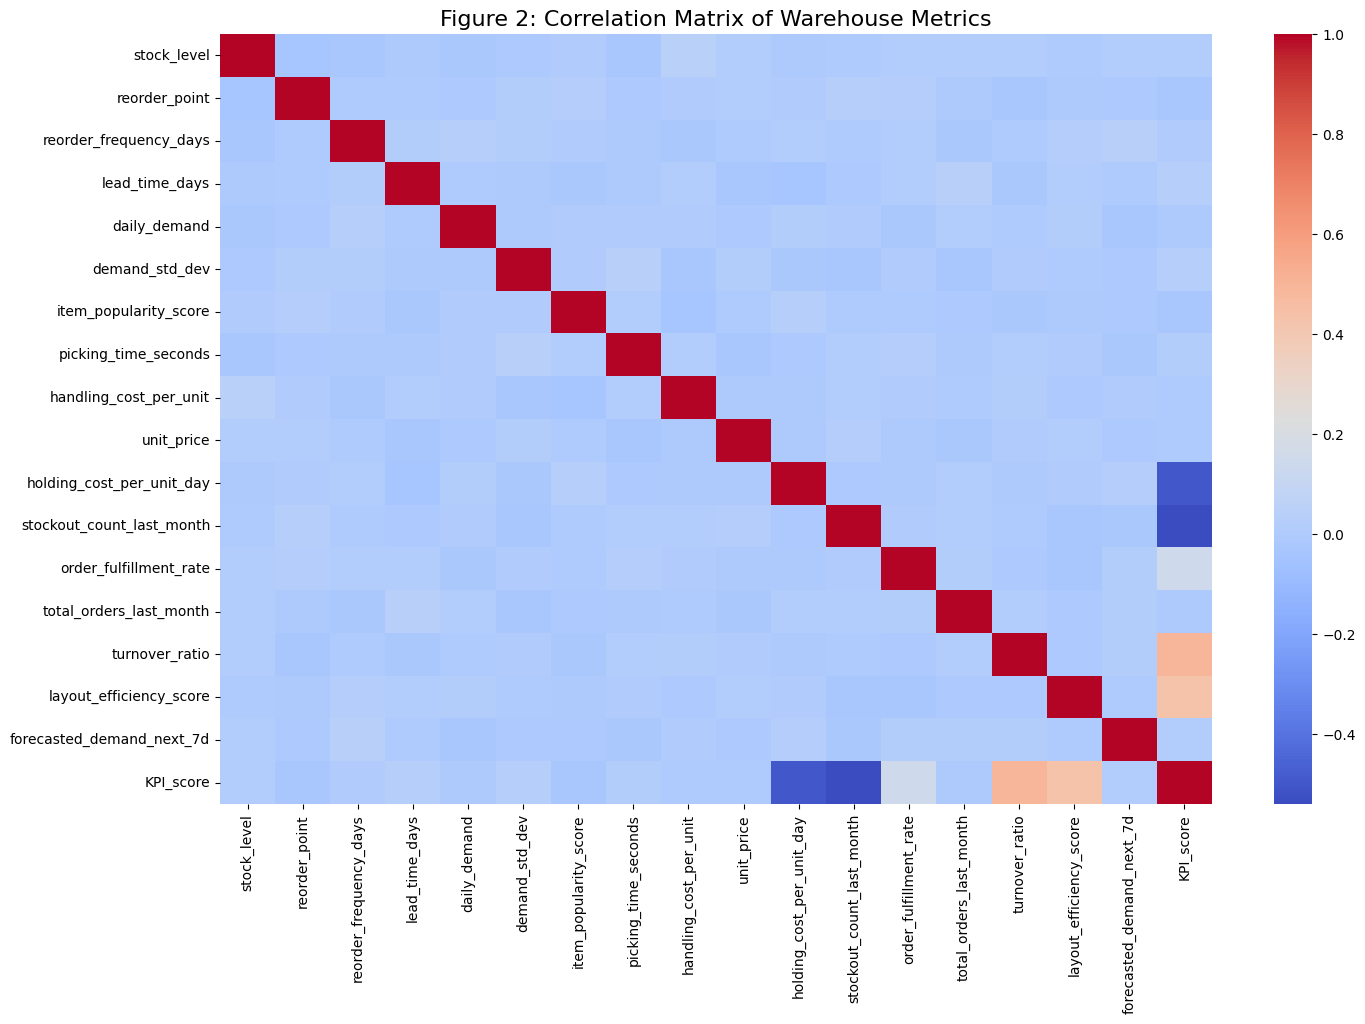

In [14]:
plt.figure(figsize=(16, 10))
numeric_cols = logistics_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = logistics_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Warehouse data', fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.boxplot(x='zone', y='picking_time_seconds', data=logistics_df, palette='viridis')
plt.title('Picking Time by Warehouse Zone')
plt.xlabel('Warehouse Zone')
plt.ylabel('Picking Time (Seconds)')

plt.subplot(1, 2, 2)
sns.boxplot(x='category', y='daily_demand', data=logistics_df, palette='plasma')
plt.title('Daily Demand by Item Category')
plt.xlabel('Item Category')
plt.ylabel('Daily Demand (Units)')

plt.suptitle('Performance Across Categories and Zones', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
#drop columns we dont need for this model
columns_to_drop = ['item_id','reorder_frequency_days','lead_time_days','demand_std_dev','handling_cost_per_unit','unit_price','holding_cost_per_unit_day','turnover_ratio','layout_efficiency_score','KPI_score','forecasted_demand_next_7d']
logistics_df = logistics_df.drop(columns=columns_to_drop)

# Display the first 5 rows of the updated DataFrame
logistics_df.head()

In [9]:
#one-hot encode data so our model understands our data
categorical_cols = ['category', 'zone']
logistics_df_encoded = pd.get_dummies(logistics_df, columns=categorical_cols, prefix=categorical_cols)

# Convert the 'last_restock_date' column to a standardized datetime format (YYYY-MM-DD)
logistics_df_encoded['last_restock_date'] = pd.to_datetime(logistics_df_encoded['last_restock_date']).dt.strftime('%Y-%m-%d')

In [11]:
logistics_df_encoded.head()

,item_id,stock_level,reorder_point,daily_demand,item_popularity_score,storage_location_id,picking_time_seconds,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,last_restock_date,category_Apparel,category_Automotive,category_Electronics,category_Groceries,category_Pharma,zone_A,zone_B,zone_C,zone_D
0,ITM10000,283,21,49.85,0.43,L82,106,0,0.80,700,2024-02-17,False,False,False,False,True,False,True,False,False
1,ITM10001,301,52,23.34,0.69,L15,45,3,0.79,736,2024-10-01,False,True,False,False,False,True,False,False,False
2,ITM10002,132,60,37.69,0.62,L4,177,7,0.75,814,2024-04-07,False,False,False,True,False,False,True,False,False
3,ITM10003,346,46,33.69,0.21,L95,39,0,0.96,994,2024-01-27,False,True,False,False,False,True,False,False,False
4,ITM10004,49,55,49.58,0.31,L36,35,5,0.83,299,2024-05-17,False,True,False,False,False,False,False,False,True


In [ ]:
#mixmax scaler to avoid bias because of largw numbers
scaler = MinMaxScaler()
numeric_cols = ['daily_demand', 'total_orders_last_month', 'stock_level', 'reorder_point', 'stockout_count_last_month', 'order_fulfillment_rate', 'item_popularity_score','picking_time_seconds']
logistics_df_encoded[numeric_cols] = scaler.fit_transform(logistics_df_encoded[numeric_cols])
logistics_df_encoded.head()

In [19]:
# Focusing on 'daily_demand' as the primary time-series feature
demand_features = ['daily_demand']
logistics_df_demand = logistics_df_encoded[demand_features].copy()

data = logistics_df_demand['daily_demand'].values
timesteps = 10

X, y = [], []
for i in range(len(data) - timesteps):
    X.append(data[i:(i + timesteps)])
    y.append(data[i + timesteps])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For demonstration, we'll train on the full dataset to show the fit.
# (Normally we'd use a train/test split as in the previous script)
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(timesteps, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2032
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0849
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0828
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0832
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0841
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0833
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0811
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0844
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0857
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0835
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0814
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0830
Epoch 13/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0826
Epoch 14/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0819
Epoch 15/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0814
Epoch 16/20
80/80 ━━━━━━━━━━

In [21]:
# Evaluate the model on the test set
loss = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (Mean Squared Error): {loss}')

Test Loss (Mean Squared Error): 0.08081419765949249


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


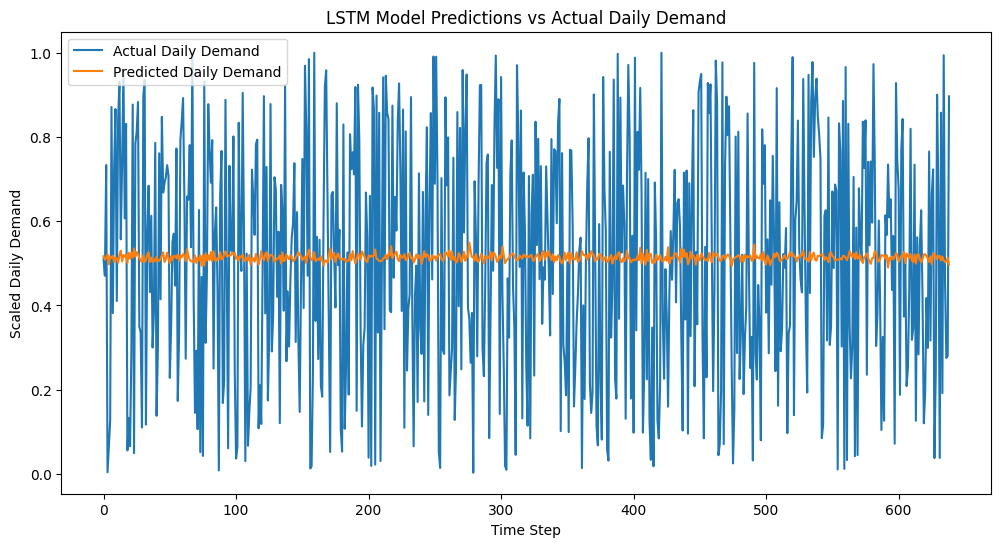

In [22]:
# Visualize predictions vs actual values
predictions = model_lstm.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Daily Demand')
plt.plot(predictions, label='Predicted Daily Demand')
plt.title('Predictions vs Actual Daily Demand')
plt.xlabel('Time Step')
plt.ylabel('Scaled Daily Demand')
plt.legend()
plt.show()